# DICOM Multiple Bed Positions

**Special thanks to Dr. Peyman Sheikhzadeh at the Tehran University Of Medical Science for providing this anonymized data**

In [1]:
import os
import numpy as np
from pytomography.io.SPECT import dicom
from pytomography.transforms.SPECT import SPECTAttenuationTransform, SPECTPSFTransform
from pytomography.algorithms import OSEM
from pytomography.projectors.SPECT import SPECTSystemMatrix
from pytomography.likelihoods import PoissonLogLikelihood
from pytomography.utils import print_collimator_parameters
import matplotlib.pyplot as plt
import pydicom
import torch
import shutil

In [2]:
# change this to where you downloaded the data
save_path = '/mnt/mydisk2/pytomo_tutorial_data/SPECT'

## Part 1: Opening Data

This tutorial involves reconstructing Lu-177 SPECT data from multiple bed positions and stitching the resulting reconstructions into a single reconstruction consisting of the full patient.

First we'll specify the projection data file paths: each one corresponds to a different bed position.

In [3]:
files_NM = [
    os.path.join(save_path, 'Lu177-PSMA-TwoBed', 'bed1_projections.dcm'),
    os.path.join(save_path, 'Lu177-PSMA-TwoBed', 'bed2_projections.dcm'),
]
path_CT = os.path.join(save_path, 'Lu177-PSMA-TwoBed', 'CT')
files_CT = [os.path.join(path_CT, file) for file in os.listdir(path_CT)]

Lets print the energy window information so we can assign the correct indices to the photopeak and scatter

In [4]:
dicom.print_energy_window_info(files_NM[0])

Index 0:   Name: "Lu177_EM", Energies: [101.7keV, 124.3keV]
Index 1:   Name: "Lu177_EM", Energies: [187.2keV, 228.8keV]
Index 2:   Name: "sc4_SC", Energies: [229.63keV, 251.16keV]
Index 3:   Name: "sc3_SC", Energies: [166.89keV, 186.31keV]
Index 4:   Name: "sc2_SC", Energies: [124.32keV, 134.68keV]
Index 5:   Name: "96.0_SC", Energies: [91.2keV, 100.8keV]


In this case since we are imaging the 208 keV peak, the `index_peak` is 1, the `index_lower` is 3 and the `index_upper` is 2 as confirmed by the `EnergyWindowInformationSequence`

Ideally, stitching of multiple bed positions would consist of (i) concatenating projections in projection space and (ii) reconstructing the concatenated projections. Unfortunately, the two bed positions may be acquired at different radial positions per projection, so the seperate bed positions need to be reconstructed seperately and then stitched together after reconstruction.

Note that if we load the projections seperately...

In [5]:
projections_upper_fov = dicom.get_projections(files_NM[0])
projections_lower_fov = dicom.get_projections(files_NM[1])

...and then plot the photopeaks...

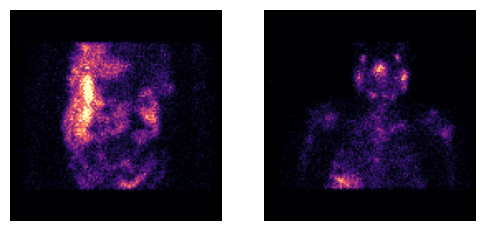

In [6]:
# Plot [1,0] for index 1 (photopeak) and index 0 (angle 0)
plt.figure(figsize=(6,3))
plt.subplot(121)
plt.imshow(projections_lower_fov[1,0].cpu().T, vmax=40, cmap='magma', origin='lower')
plt.axis('off')
plt.subplot(122)
plt.imshow(projections_upper_fov[1,0].cpu().T, vmax=40, cmap='magma', origin='lower')
plt.axis('off')
plt.show()

...there are sharp cutoffs at the edges of the FOV. When reconstructing the data and then stitching together, this can lead to stitching artefacts at the edges of the field of view. 

Instead, we can take advantage of the fact that the projections are slightly overlapping to fill in missing data in each bed position.

* *Note: at the edges, this means we may be mixing data from two different radial positions per projection (which means PSF modeling may be ever so slightly invalid). This, however, is still not nearly as egregious as having zeros in those locations. Since the stitching seams after reconstruction are at the central points of projection overlap of the projections, the end result of this has no noteworthy impact. (I'm certain the vendors do something similar to this, and if not, they really should.)*

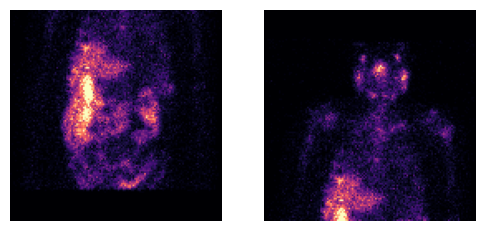

In [7]:
projections_upper, projections_lower = projectionss = dicom.load_multibed_projections(files_NM)
# Plot [1,0] for index 1 (photopeak) and index 0 (angle 0)
plt.figure(figsize=(6,3))
plt.subplot(121)
plt.imshow(projections_lower[1,0].cpu().T, vmax=40, cmap='magma', origin='lower')
plt.axis('off')
plt.subplot(122)
plt.imshow(projections_upper[1,0].cpu().T, vmax=40, cmap='magma', origin='lower')
plt.axis('off')
plt.show()

Before we reconstruct, lets examine the attenuation maps and corresponding projections to ensure the data is properly aligned

* Note the attenuation map for each set of projections is derived from a single set of CT files `files_CT` corresponding to a wholebody field of view. The attenuation map for a specific bed position is obtained via alignment.

Given photopeak energy 208.0 keV and CT energy 120 keV from the CT DICOM header, the HU->mu conversion from the following configuration is used: 208.0 keV SPECT energy, 120 keV CT energy, and scanner model optimact540
Given photopeak energy 208.0 keV and CT energy 120 keV from the CT DICOM header, the HU->mu conversion from the following configuration is used: 208.0 keV SPECT energy, 120 keV CT energy, and scanner model optimact540


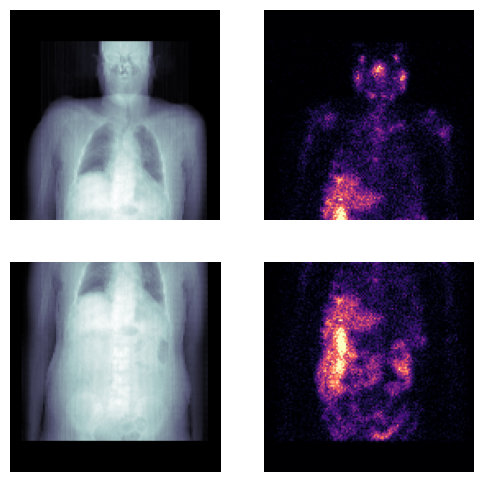

In [8]:
attenuation_map1 = dicom.get_attenuation_map_from_CT_slices(files_CT, files_NM[0], index_peak=1)
attenuation_map2 = dicom.get_attenuation_map_from_CT_slices(files_CT, files_NM[1], index_peak=1)
plt.figure(figsize=(6,6))
plt.subplot(221)
plt.imshow(attenuation_map1.sum(axis=1).cpu().T, cmap='bone', origin='lower')
plt.axis('off')
plt.subplot(222)
plt.imshow(projections_upper[1,0].cpu().T, vmax=40, cmap='magma', origin='lower')
plt.axis('off')
plt.subplot(223)
plt.imshow(attenuation_map2.sum(axis=1).cpu().T, cmap='bone', origin='lower')
plt.axis('off')
plt.subplot(224)
plt.imshow(projections_lower[1,0].cpu().T, vmax=40, cmap='magma', origin='lower')
plt.axis('off')
plt.show()

## Part 2: Reconstruction

The following function performs reconstruction of a single bed position (if you are unfamiliar with this, please see the introductory DICOM tutorial). There are a few changes:
* The `dicom.get_energy_window_scatter_estimate_projections` is now used, since we have manually modified the projection data before reconstructing. This allows us to input the projection data manually (as opposed to automatically loading it from ``file_NM``)


In [9]:
object_meta, proj_meta = dicom.get_metadata(files_NM[0], index_peak=1)

In [10]:
def reconstruct_singlebed(i):
    # Change these depending on your file:
    index_peak = 1
    index_lower = 3
    index_upper = 2
    projections = projectionss[i]
    file_NM = files_NM[i]
    object_meta, proj_meta = dicom.get_metadata(file_NM, index_peak=index_peak)
    photopeak = projections[index_peak]
    scatter = dicom.get_energy_window_scatter_estimate_projections(file_NM, projections, index_peak, index_lower, index_upper)
    # Build system matrix
    attenuation_map = dicom.get_attenuation_map_from_CT_slices(files_CT, file_NM, index_peak=index_peak)
    psf_meta = dicom.get_psfmeta_from_scanner_params('GI-MEGP', energy_keV=208)
    att_transform = SPECTAttenuationTransform(attenuation_map)
    psf_transform = SPECTPSFTransform(psf_meta)
    # Create system matrix
    system_matrix = SPECTSystemMatrix(
        obj2obj_transforms = [att_transform,psf_transform],
        proj2proj_transforms= [],
        object_meta = object_meta,
        proj_meta = proj_meta)
    likelihood = PoissonLogLikelihood(system_matrix, photopeak, additive_term=scatter)
    reconstruction_algorithm = OSEM(likelihood)
    return reconstruction_algorithm(n_iters=4, n_subsets=8)

From this we can reconstruct each bed position seperately:

In [11]:
recon_upper = reconstruct_singlebed(0)
recon_lower = reconstruct_singlebed(1)

Given photopeak energy 208.0 keV and CT energy 120 keV from the CT DICOM header, the HU->mu conversion from the following configuration is used: 208.0 keV SPECT energy, 120 keV CT energy, and scanner model optimact540
Given photopeak energy 208.0 keV and CT energy 120 keV from the CT DICOM header, the HU->mu conversion from the following configuration is used: 208.0 keV SPECT energy, 120 keV CT energy, and scanner model optimact540


We can view each reconstruction seperately

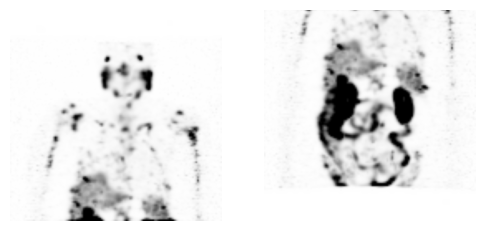

In [12]:
plt.figure(figsize=(6,3))
plt.subplot(121)
plt.imshow(recon_upper.max(axis=1)[0].cpu().T, cmap='Greys', vmax=5, interpolation='gaussian', origin='lower')
plt.axis('off')
plt.subplot(122)
plt.imshow(recon_lower.max(axis=1)[0].cpu().T, cmap='Greys', vmax=5, interpolation='gaussian', origin='lower')
plt.axis('off')
plt.show()

To stitch these reconstructed images together, we use the `dicom.stitch_multibed` function. When using this function, its important that the `files_NM` argument is provided in the same order as the `recons` (i.e. the first recon should correspond to the first `files_NM`)

In [13]:
recon_stitched = dicom.stitch_multibed(
    recons=torch.stack([recon_upper, recon_lower]),
    files_NM = files_NM)

Now we can view the stitched image

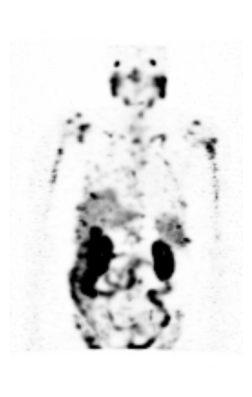

In [14]:
maximum_intensity_projection = recon_stitched.max(axis=1)[0].cpu()
plt.figure(figsize=(3,6))
plt.imshow(maximum_intensity_projection.T, cmap='Greys', vmax=5, interpolation='gaussian', origin='lower')
plt.axis('off')
plt.show()

When saving the DICOM image, choose the `file_NM` that corresponds to the most superior one

In [15]:
save_path = os.path.join(save_path, 'Lu177-PSMA-TwoBed', 'pytomo_recon')
if os.path.exists(save_path) and os.path.isdir(save_path):
    shutil.rmtree(save_path)
dicom.save_dcm(
    save_path = save_path,
    object = recon_stitched,
    file_NM = files_NM[0],
    recon_name = 'OSEM_4it_8ss',
    scale_by_number_projections=True,
    single_dicom_file=True)

The data can then be imported into any platform one chooses